In [1]:
# only for colab
!git clone https://github.com/yellamnaidukottavalasa555/AI_in_Industry_Project

Cloning into 'AI_in_Industry_Project'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 153
Receiving objects: 100% (170/170), 22.15 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("AI_in_Industry_Project/notebooks")
import utils.utils as utils
import utils.models as models
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.callbacks as callbacks
from sklearn.metrics import r2_score
batch_size = 64
n_node = 15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
try:
  from google.colab import drive
  drive.mount("/content/drive")
  COLAB = True
  PATH = "/content/drive/MyDrive/Artificial Intelligence in Industry/project/data/HPC/new_data"
except:
  COLAB = False

Mounted at /content/drive


In [ ]:

def get_errors_splits(idxs, min=-1, i=-1):
  idxs = [id1  for id1, id2 in zip(idxs[:-1], idxs[1:]) if id1 - id2 != i]
  if i < min:
    return idxs
  return get_errors_splits(idxs, min, i-1)
def split_for_failure(dt, node, min=-1):
  idxs = (dt[dt.label==2].index)
  idxs = get_errors_splits(idxs, min=min)
  splits = np.split((dt.index), idxs)
  dt_list = []
  for i, split in (enumerate(splits)):
      tmp = dt.iloc[split].copy()
      if(all(tmp.label == 2)):
        continue
      tmp['cycle'] = list(range(len(split)))
      tmp["node"] = f"{node}_{str(i)}"
      dt_list.append(tmp)
  return dt_list
def compute_rul(dt, field):
  cnts = dt[dt.label == 0].groupby("node")[["timestamp"]].count()
  cnts.columns = ['ftime']
  dt = dt.join(cnts, on=field)
  dt['rul'] = dt['ftime'] - dt['cycle']
  dt.drop(columns=['ftime'], inplace=True)
  return dt


In [ ]:
dt_list = []
for i, entry in tqdm(enumerate(Path(PATH).glob("*.gzip"))):
  dt = pd.read_parquet(entry).reset_index()
  dt.drop(columns="index", inplace=True)
  dt.drop(columns = "label", inplace=True)
  dt.rename(columns={"New_label": "label"}, inplace=True)

  # dt_list = [dt]
  dt_list.extend(split_for_failure(dt, entry.stem, -22))
  if i > n_node:
    break
  
dt = pd.concat(dt_list, ignore_index=True)
dt = dt.copy()
# dt = dt[["node"]+["n_failure"]+["cycle"] + list(dt.columns[:-3])]


16it [00:22,  1.39s/it]


In [ ]:
dt.isna().any().any()

True

In [ ]:
dt.dropna(axis = 1, inplace=True)

In [ ]:
dt = compute_rul(dt, ["node"])
dt = dt.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
dt = dt[["node"]+["cycle"]+["label"]+list(dt.columns[:-45])+ ["rul"]]

In [ ]:
dt.head()

,node,cycle,label,timestamp,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,...,max:load_one,min:load_one,avg:mem_buffers,var:mem_buffers,max:mem_buffers,min:mem_buffers,avg:mem_cached,var:mem_cached,max:mem_cached,rul
0,r206n18_0,0,0,2020-06-01 00:00:00,26.500000,0.022857,26.6,26.2,34.0,0.0,...,4.05,4.05,4032.0,0.0,4032,4032,1.987776e+06,13653.333333,1987904.0,961
1,r206n18_0,1,0,2020-06-01 00:15:00,26.415385,0.003077,26.6,26.4,34.0,0.0,...,4.12,4.00,4032.0,0.0,4032,4032,1.987072e+06,0.000000,1987072.0,960
2,r206n18_0,2,0,2020-06-01 00:30:00,26.416667,0.003333,26.6,26.4,34.0,0.0,...,4.05,4.00,4032.0,0.0,4032,4032,1.987221e+06,1365.333333,1987264.0,959
3,r206n18_0,3,0,2020-06-01 00:45:00,26.400000,0.000000,26.4,26.4,34.0,0.0,...,4.09,4.04,4032.0,0.0,4032,4032,1.987456e+06,0.000000,1987456.0,958
4,r206n18_0,4,0,2020-06-01 01:00:00,26.400000,0.000000,26.4,26.4,34.0,0.0,...,4.11,4.06,4032.0,0.0,4032,4032,1.987533e+06,819.200000,1987584.0,957


In [ ]:
print(dt[dt.label == 0].shape)
print(dt[dt.label==2].shape)

(231763, 296)
(8926, 296)


In [ ]:
dt_in = dt.columns[5:-1]
#dt.drop(columns=dt_in[2::4], inplace=True)
#dt.drop(columns=dt_in[3::4], inplace=True)

In [ ]:
dt.describe()

,cycle,label,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,...,max:load_one,min:load_one,avg:mem_buffers,var:mem_buffers,max:mem_buffers,min:mem_buffers,avg:mem_cached,var:mem_cached,max:mem_cached,rul
count,240689.000000,240689.000000,240689.000000,240689.000000,240689.000000,240689.000000,240689.000000,240689.000000,240689.000000,240689.000000,...,240689.000000,240689.000000,2.406890e+05,2.406890e+05,2.406890e+05,2.406890e+05,2.406890e+05,2.406890e+05,2.406890e+05,240689.000000
mean,4086.442604,0.074170,22.368579,0.026503,22.527621,22.208265,30.553360,0.052736,30.690941,30.417510,...,18.160848,15.024664,2.326479e+03,2.261027e+07,2.369598e+03,2.291583e+03,3.613764e+06,4.239316e+11,3.683664e+06,3932.459281
std,3445.068515,0.377942,3.450636,0.117152,3.417433,3.489558,3.057750,0.119996,3.050073,3.081219,...,98.987402,81.631591,1.309798e+04,3.641110e+09,1.584913e+04,1.208769e+04,7.876166e+06,4.293861e+13,8.078452e+06,3445.123394
min,0.000000,0.000000,10.253333,0.000000,10.400000,10.000000,20.000000,0.000000,20.000000,20.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.978112e+05,0.000000e+00,2.480640e+05,-2298.000000
25%,852.000000,0.000000,19.586667,0.002667,19.800000,19.400000,28.600000,0.000000,29.000000,28.000000,...,0.120000,0.000000,6.400000e+01,0.000000e+00,6.400000e+01,6.400000e+01,1.428213e+06,0.000000e+00,1.436288e+06,733.000000
50%,3305.000000,0.000000,23.426667,0.009524,23.600000,23.400000,31.000000,0.000000,31.000000,31.000000,...,4.310000,4.040000,6.400000e+01,0.000000e+00,6.400000e+01,6.400000e+01,2.093141e+06,1.024000e+03,2.108288e+06,3163.000000
75%,6706.000000,0.000000,25.066667,0.016381,25.200000,25.000000,33.000000,0.066667,33.000000,33.000000,...,22.720000,16.800000,5.248000e+03,0.000000e+00,5.248000e+03,5.248000e+03,2.881152e+06,4.022857e+03,2.897792e+06,6563.000000
max,13131.000000,2.000000,34.986667,20.086857,35.400000,34.800000,39.933333,9.066667,41.000000,39.000000,...,9621.890000,8261.860000,1.780992e+06,8.524360e+11,1.789632e+06,1.780992e+06,2.265593e+08,1.442021e+16,2.327133e+08,12998.000000


In [ ]:
print(len(dt[dt_in].columns[dt[dt_in].mean() == 0]))
print(len(dt[dt_in].columns[dt[dt_in].std() == 0]))

23
29


In [ ]:
drop_columns =  list(dt[dt_in].columns[dt[dt_in].mean() == 0])
drop_columns.extend(list(dt[dt_in].columns[dt[dt_in].std() == 0]))


In [ ]:
dt.drop(columns = drop_columns, inplace=True)


In [ ]:
dt_in = dt.columns[5:-1]

In [ ]:
groups = dt.groupby(["node"])
for group_id, group_df in groups:
  hpcsv = group_df.copy()
  hpcsv = hpcsv.reset_index()
  break

In [ ]:
print(hpcsv.shape)
print(hpcsv[hpcsv["label"] == 2].shape)

(962, 268)
(15, 268)


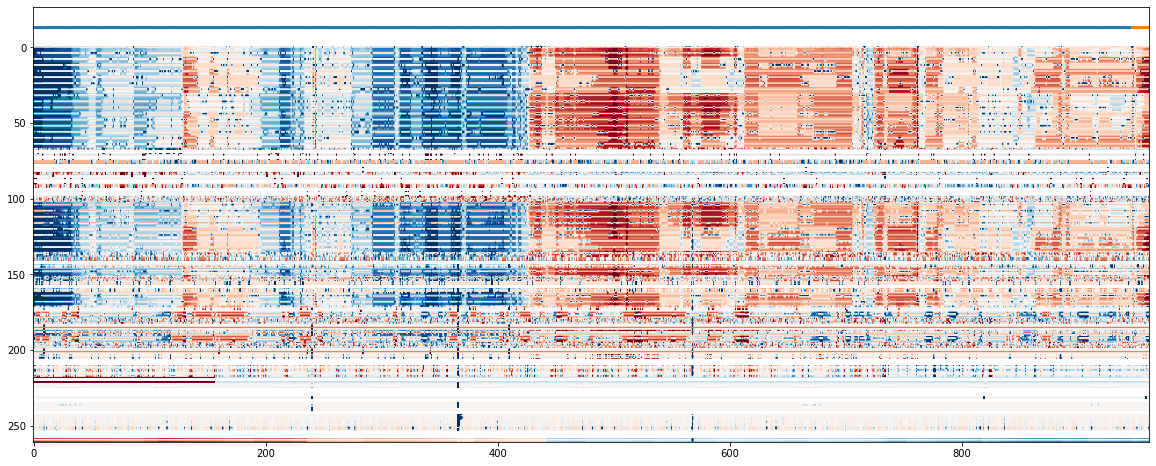

In [ ]:
#hpcsv = dt.iloc[:dt[dt.label == 2].index[0]].copy()
hpcsv[dt_in] = (hpcsv[dt_in]- hpcsv[dt_in].mean()) / hpcsv[dt_in].std()
plt.figure(figsize=(20,8))
plt.imshow(hpcsv[dt_in].T.iloc[:, :], aspect='auto', vmin=-1.96, vmax=1.96, cmap='RdBu')

ncol = len(dt_in)
lvl = -0.05*ncol
labels = pd.Series(index=hpcsv.index, data=(hpcsv['label'] != 0), dtype=int)
plt.scatter(labels.index, np.ones(len(labels)) * lvl, s=4, color=plt.get_cmap('tab10')(labels))

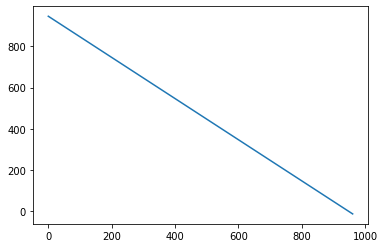

In [ ]:
plt.plot(range(len(hpcsv.rul)), hpcsv.rul)

In [ ]:
def plot_training_history(history, 
        figsize=(10,10), autoclose=True):
    if autoclose:
        plt.close('all')
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='loss')
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'], label='val. loss')
        plt.legend()
    plt.tight_layout()

In [ ]:
def plot_pred_scatter(y_pred, y_true, figsize=(10,10), autoclose=True):
    if autoclose:
        plt.close('all')
    plt.figure(figsize=figsize)
    plt.scatter(y_pred, y_true, marker='.', alpha=0.1)
    xl, xu = plt.xlim()
    yl, yu = plt.ylim()
    l, u = min(xl, yl), max(xu, yu)
    plt.plot([l, u], [l, u], ':', c='0.3')
    plt.xlim(l, u)
    plt.ylim(l, u)
    plt.xlabel('prediction')
    plt.ylabel('target')
    plt.tight_layout()

## supervised 20% unsupervised 55%

In [ ]:
failures = utils.split_by_field(dt, ["node"])

trs_ratio = 0.20
tru_ratio  =0.55
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio, verbose=1, field="node")
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)
tru_s_by_n = utils.split_by_field(tru_s, 'node')
tru_st = utils.cut_off(tru_s, "node")
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1


Num. machine: 21 (supervised), 58 (unsupervised), 27 (test)


### Baseline model

#### Training

In [ ]:
model = models.MLPRegressor(len(dt_in), hidden=[32, 32])
model.compile("Adam", "mse")
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = model.fit(tr_s[dt_in], tr_s['rul'], validation_split=0.2, callbacks=cb, batch_size=batch_size, epochs=25)

Epoch 1/25
528/528 [==============================] - 2s 2ms/step - loss: 0.0761 - val_loss: 0.1546
Epoch 2/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0934
Epoch 3/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0987
Epoch 4/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0742
Epoch 5/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0867
Epoch 6/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0790
Epoch 7/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0798
Epoch 8/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0810
Epoch 9/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0886
Epoch 10/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0842

#### Evaluation

Final loss: 0.0049 (training),  0.0742 (validation)


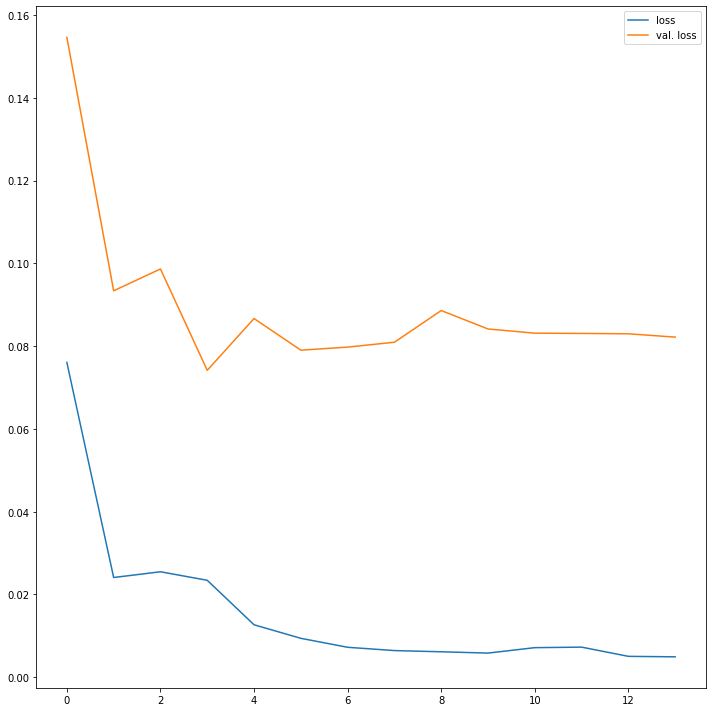

In [ ]:
plot_training_history(history)
trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f"Final loss: {trl:.4f} (training), {vll: .4f} (validation)")

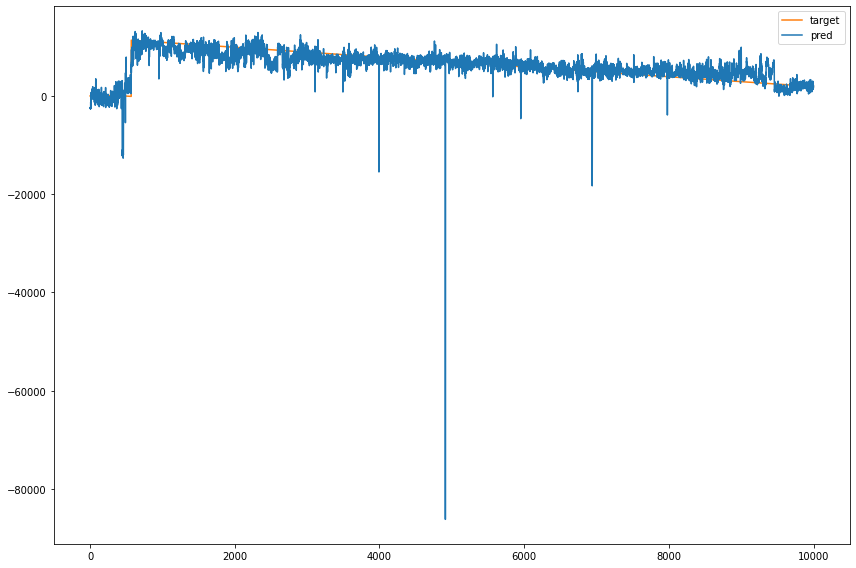

In [ ]:
stop = 10000
tr_pred = model.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tr_pred[:stop], trs['rul'][:stop], figsize=(12,8))

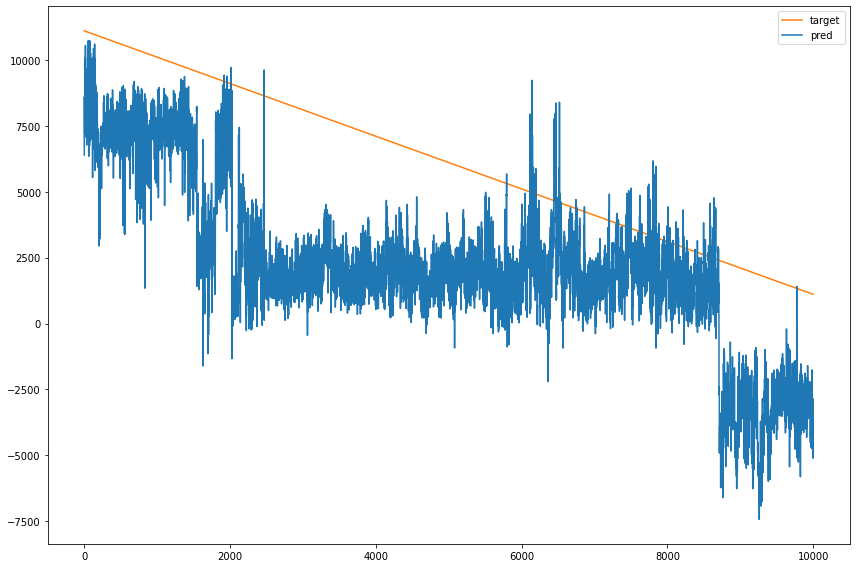

In [ ]:
tru_pred = model.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru['rul'][:stop], figsize=(12,8))

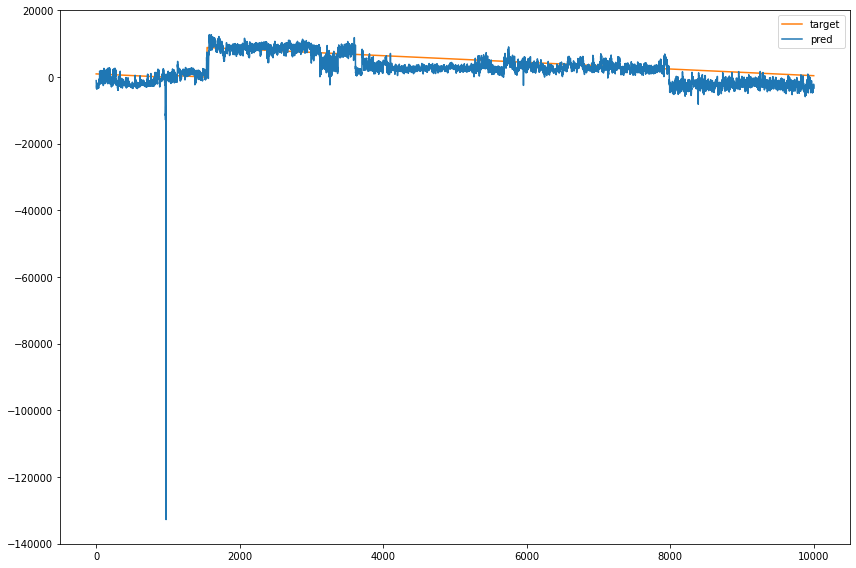

In [ ]:
ts_pred = model.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=(12,8))

In [ ]:
failtimes = dt.groupby(["node"])['cycle'].max()
failtimes.head()

node
r205n12_0      961
r205n12_1       28
r205n12_2      431
r205n12_3      582
r205n12_4    11236
Name: cycle, dtype: int64

In [ ]:
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

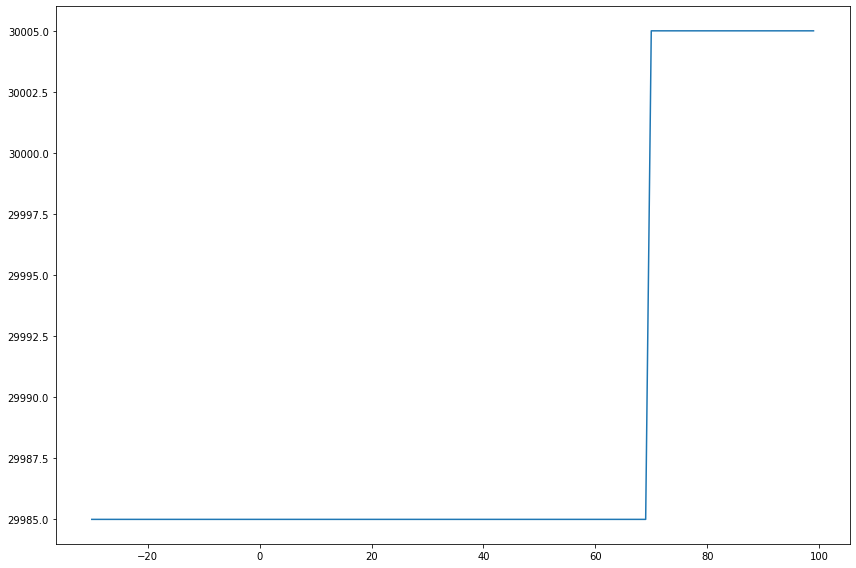

Optimal threshold for the training set: -30


In [ ]:

cmodel = models.RULCostModel(maintenance_cost, safe_interval)

th_range = np.arange(-30, 100)
tr_thr = utils.opt_threshold_and_plot(trs.node.values, tr_pred, th_range, cmodel, figsize=(12, 8))
print(f"Optimal threshold for the training set: {tr_thr}")

In [ ]:
tr_set = trs_s.node.unique()
tru_set = tru_s.node.unique()
ts_set = ts_s.node.unique()

tr_c, tr_f, tr_sl = cmodel.cost(trs.node.values, tr_pred, tr_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru.node.values, tru_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts.node.values, ts_pred, tr_thr, return_margin=True)

print(f'Cost: {tr_c} (training), {tru_c} (unsupervised), {ts_c} (test)')

print(f' Avg.fails: {tr_f/len(tr_set)} (training), {tru_f/len(tru_set)} (unsupervised), {ts_f/len(ts_set)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_set)} (training), {tru_sl/len(tru_set)} , {ts_sl/len(ts_set)} (test)')

Cost: 29985 (training), 90706 (unsupervised), 47847 (test)
 Avg.fails: 0.14285714285714285 (training), 0.13793103448275862 (unsupervised), 0.14814814814814814 (test)
Avg. slack: 1499.5238095238096 (training), 1968.8275862068965 , 2251.8888888888887 (test)


### Lagrangian Regressor model

#### Training

In [ ]:
model = models.LagDualRULRegressor(len(dt_in), trmaxrul, hidden=[32,32])
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size, field="node")
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
model.compile(optimizer='Adam', run_eagerly=False)
history = model.fit(batch_gen, callbacks=cb, epochs=25)


Epoch 1/25
2719/2719 [==============================] - 295s 108ms/step - loss: -0.0335 - mse: 0.0225 - cst: 0.0673
Epoch 2/25
2719/2719 [==============================] - 307s 113ms/step - loss: -0.0149 - mse: 0.0087 - cst: 0.0186
Epoch 3/25
2719/2719 [==============================] - 325s 120ms/step - loss: -0.0253 - mse: 0.0075 - cst: 0.0412
Epoch 4/25
2719/2719 [==============================] - 325s 119ms/step - loss: -0.0070 - mse: 0.0042 - cst: 0.0058
Epoch 5/25
2719/2719 [==============================] - 325s 120ms/step - loss: -0.0063 - mse: 0.0037 - cst: 0.0045
Epoch 6/25
2719/2719 [==============================] - 329s 121ms/step - loss: -0.0052 - mse: 0.0031 - cst: 0.0028
Epoch 7/25
2719/2719 [==============================] - 326s 120ms/step - loss: -0.0051 - mse: 0.0029 - cst: 0.0018
Epoch 8/25
2719/2719 [==============================] - 325s 119ms/step - loss: -0.0062 - mse: 0.0035 - cst: 0.0013
Epoch 9/25
2719/2719 [==============================] - 324s 119ms/step 

#### Evaluation

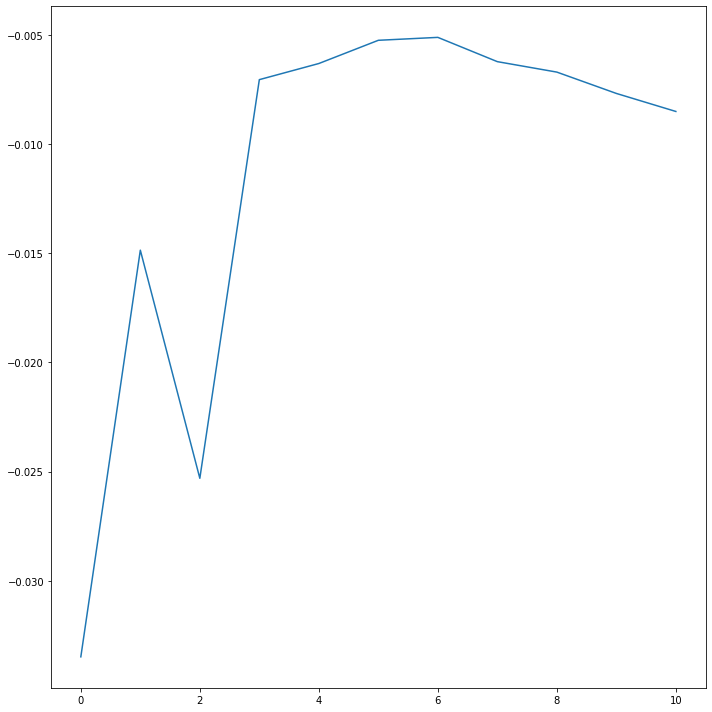

In [ ]:
plot_training_history(history)

R2 score: 0.6391533990853389


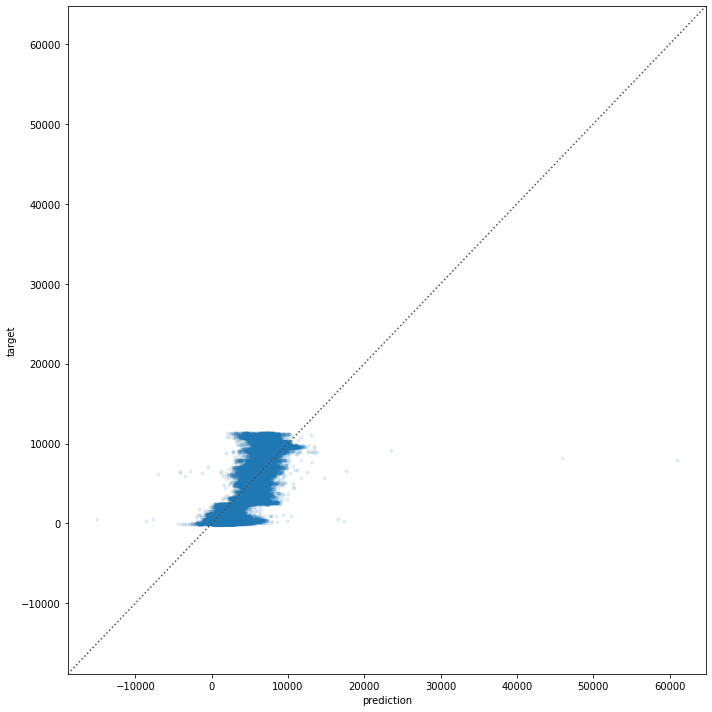

In [ ]:
tr_pred = model.predict(trs_s[dt_in]).ravel() * trmaxrul
plot_pred_scatter(tr_pred, trs['rul'])
print(f'R2 score: {r2_score(trs["rul"], tr_pred)}')

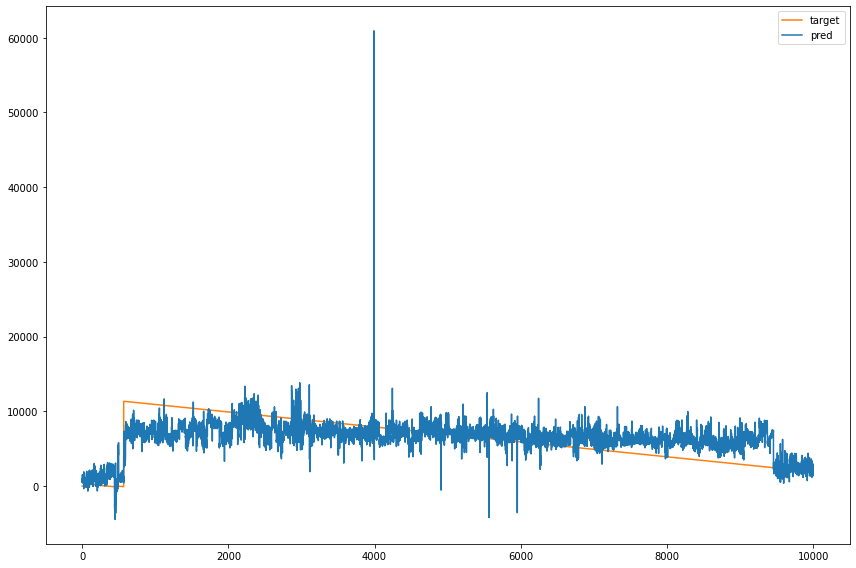

In [ ]:

utils.plot_rul(tr_pred[:stop], trs['rul'][:stop], figsize=(12,8))

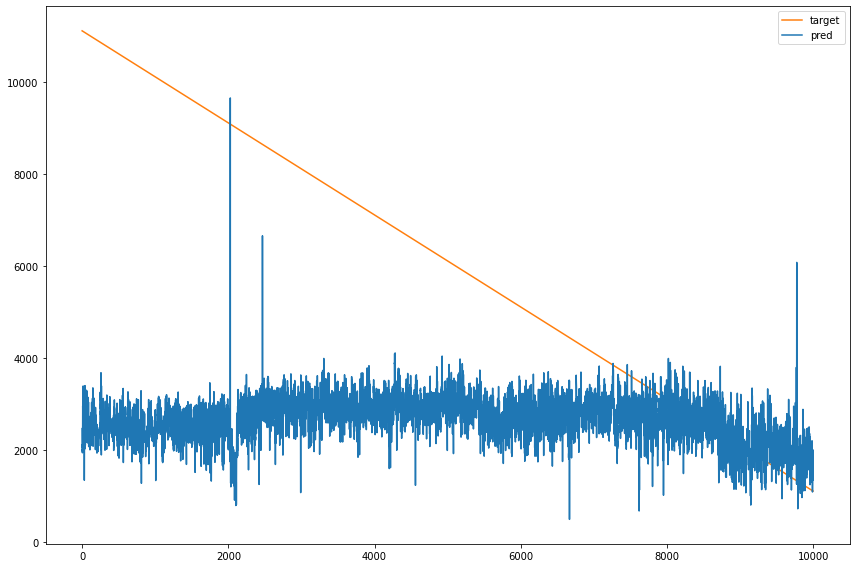

In [ ]:
tru_pred = model.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru['rul'][:stop], figsize=(12,8))

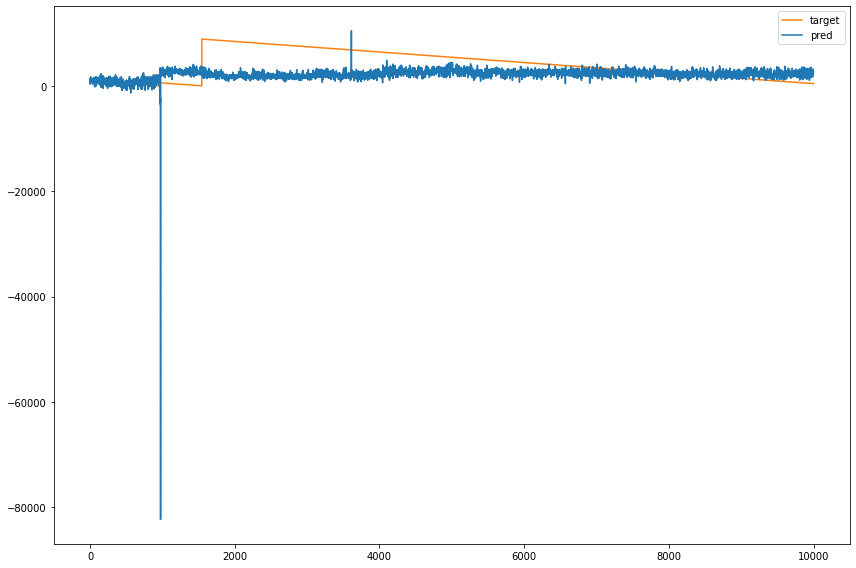

In [ ]:
ts_pred = model.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=(12,8))

In [ ]:
failtimes = dt.groupby(["node"])['cycle'].max()
failtimes.head()

node
r205n12_0      961
r205n12_1       28
r205n12_2      431
r205n12_3      582
r205n12_4    11236
Name: cycle, dtype: int64

In [ ]:
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

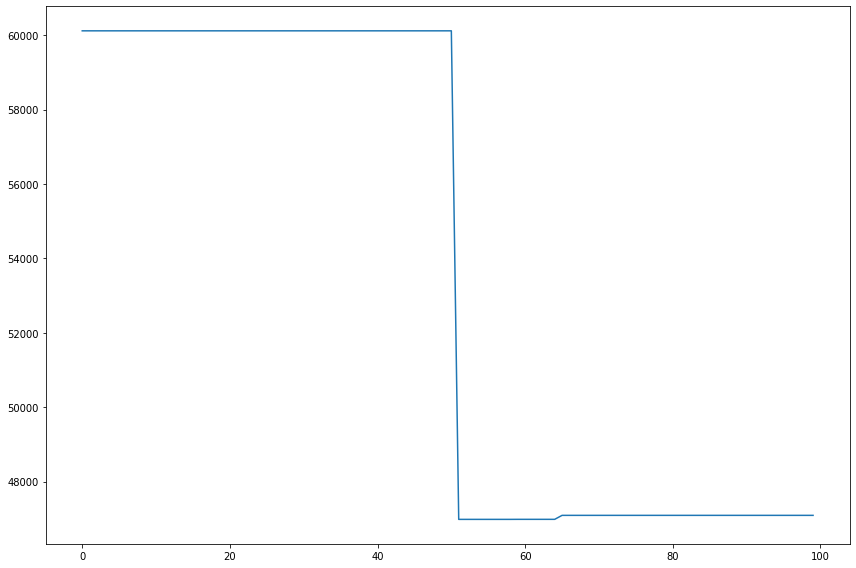

Optimal threshold for the training set: 51


In [ ]:

cmodel = models.RULCostModel(maintenance_cost, safe_interval)

th_range = np.arange(0, 100)
tr_thr = utils.opt_threshold_and_plot(trs.node.values, tr_pred, th_range, cmodel, figsize=(12, 8))
print(f"Optimal threshold for the training set: {tr_thr}")

In [ ]:
tr_set = trs_s.node.unique()
tru_set = tru_s.node.unique()
ts_set = ts_s.node.unique()

tr_c, tr_f, tr_sl = cmodel.cost(trs.node.values, tr_pred, tr_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru.node.values, tru_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts.node.values, ts_pred, tr_thr, return_margin=True)

print(f'Cost: {tr_c} (training), {tru_c} (unsupervised), {ts_c} (test)')

print(f' Avg.fails: {tr_f/len(tr_set)} (training), {tru_f/len(tru_set)} (unsupervised), {ts_f/len(ts_set)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_set)} (training), {tru_sl/len(tru_set)} , {ts_sl/len(ts_set)} (test)')

Cost: 46986 (training), 215963 (unsupervised), 97191 (test)
 Avg.fails: 0.23809523809523808 (training), 0.3103448275862069 (unsupervised), 0.3333333333333333 (test)
Avg. slack: 1045.6190476190477 (training), 1160.7931034482758 , 1211.037037037037 (test)


In [ ]:
import tensorflow as tf
class CstBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, in_cols, batch_size=32, seed=42, field="machine"):
        super(CstBatchGenerator).__init__()
        self.data = data
        self.in_cols = in_cols
        self.dpm = utils.split_by_field(data, field)
        self.rng = np.random.default_rng(seed)
        self.batch_size = batch_size
        # Build the first sequence of batches
        self.__build_batches()

    def __len__(self):
        return len(self.batches)

    # def __getitem__(self, index):
    #     idx = self.batches[index]
    #     mcn = self.machines[index]
    #     x = self.data[self.in_cols].loc[idx].values
    #     y = self.data['rul'].loc[idx].values
    #     return x, y


    def __getitem__(self, index):
        idx = self.batches[index]
        # mcn = self.machines[index]
        x = self.data[self.in_cols].loc[idx].values
        y = self.data['rul'].loc[idx].values.astype(np.float32)
        flags = (y != -1)
        info = np.vstack((y, flags, idx)).T
        return x, info

    def on_epoch_end(self):
        self.__build_batches()

    def __build_batches(self):
        self.batches = []
        self.machines = []
        # Randomly sort the machines
        # self.rng.shuffle(mcns)
        # Loop over all machines
        mcns = list(self.dpm.keys())
        for mcn in mcns:
            # Obtain the list of indices
            index = self.dpm[mcn].index
            # Padding
            padsize = self.batch_size - (len(index) % self.batch_size)
            padding = self.rng.choice(index, padsize)
            idx = np.hstack((index, padding))
            # Shuffle
            self.rng.shuffle(idx)
            # Split into batches
            bt = idx.reshape(-1, self.batch_size)
            # Sort each batch individually
            bt = np.sort(bt, axis=1)
            # Store
            self.batches.append(bt)
            self.machines.append(np.repeat([mcn], len(bt)))
        # Concatenate all batches
        self.batches = np.vstack(self.batches)
        self.machines = np.hstack(self.machines)
        # Shuffle the batches
        bidx = np.arange(len(self.batches))
        self.rng.shuffle(bidx)
        self.batches = self.batches[bidx, :]
        self.machines = self.machines[bidx]

### Multi Lagrangian Regressor model

#### Training

In [ ]:
model = models.LagDualRULRegressorMulti(len(dt_in), trmaxrul, batch_size-1, hidden=[32,32])
model.compile("Adam")
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size, field="node")
history = model.fit(batch_gen, epochs=25, callbacks=cb)

Epoch 1/25
2719/2719 [==============================] - 232s 85ms/step - loss: -0.0260 - mse: 0.0138 - cst: 0.0473
Epoch 2/25
2719/2719 [==============================] - 232s 85ms/step - loss: -0.0168 - mse: 0.0085 - cst: 0.0177
Epoch 3/25
2719/2719 [==============================] - 233s 86ms/step - loss: -0.0106 - mse: 0.0056 - cst: 0.0085
Epoch 4/25
2719/2719 [==============================] - 231s 85ms/step - loss: -0.0070 - mse: 0.0040 - cst: 0.0042
Epoch 5/25
2719/2719 [==============================] - 230s 85ms/step - loss: -0.0067 - mse: 0.0034 - cst: 0.0035
Epoch 6/25
2719/2719 [==============================] - 227s 83ms/step - loss: -0.0067 - mse: 0.0033 - cst: 0.0028
Epoch 7/25
2719/2719 [==============================] - 228s 84ms/step - loss: -0.0054 - mse: 0.0029 - cst: 0.0017
Epoch 8/25
2719/2719 [==============================] - 228s 84ms/step - loss: -0.0056 - mse: 0.0030 - cst: 0.0013
Epoch 9/25
2719/2719 [==============================] - 232s 85ms/step - loss: -

#### Evaluation

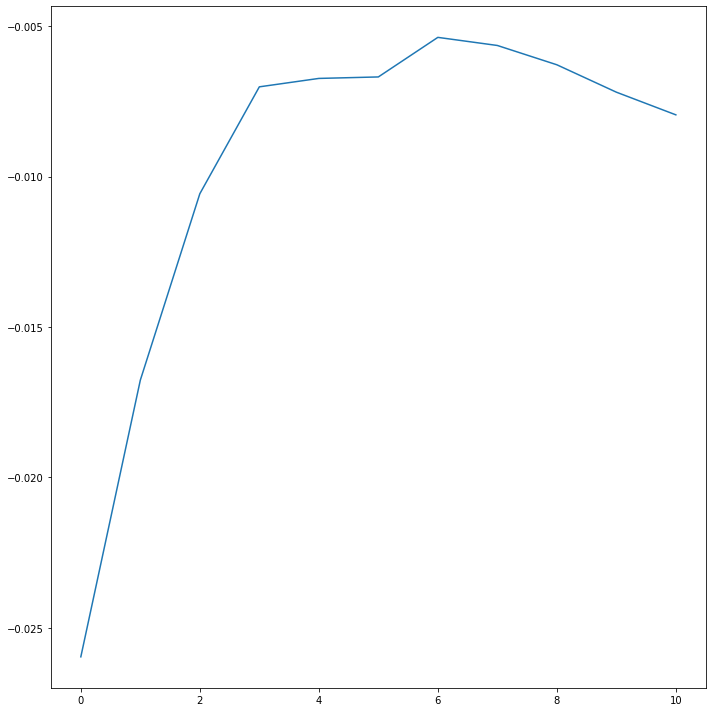

In [ ]:
plot_training_history(history)
# trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
# print(f"Final loss: {trl:.4f} (training), {vll: .4f} (validation)")

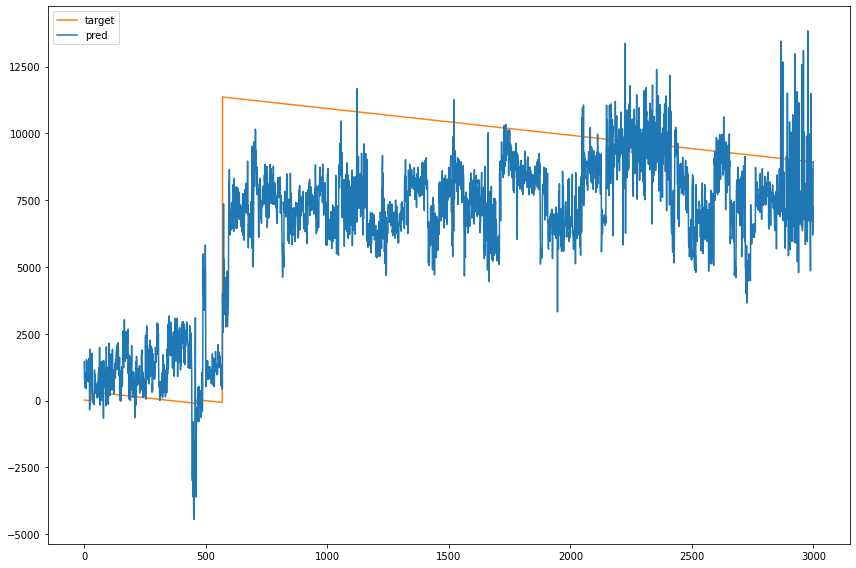

In [ ]:
stop = 3000
utils.plot_rul(tr_pred[:stop], trs['rul'][:stop], figsize=(12,8))

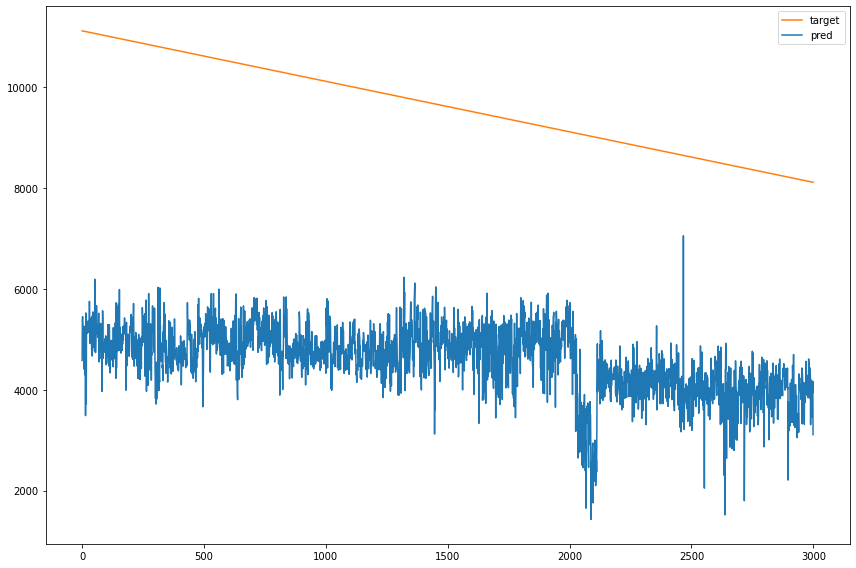

In [ ]:
tru_pred = model.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru['rul'][:stop], figsize=(12,8))

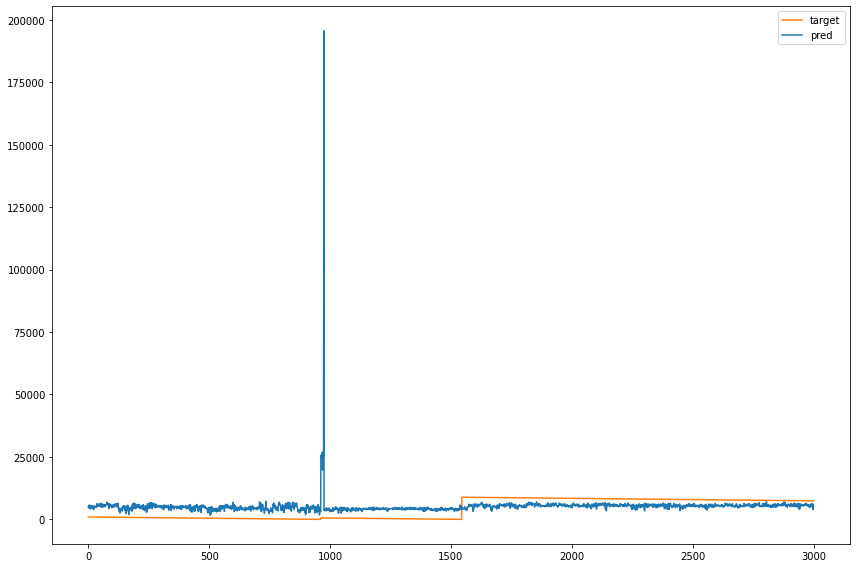

In [ ]:
ts_pred = model.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=(12,8))

In [ ]:
failtimes = dt.groupby(["node"])['cycle'].max()
failtimes.head()

node
r205n12_0      961
r205n12_1       28
r205n12_2      431
r205n12_3      582
r205n12_4    11236
Name: cycle, dtype: int64

In [ ]:
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

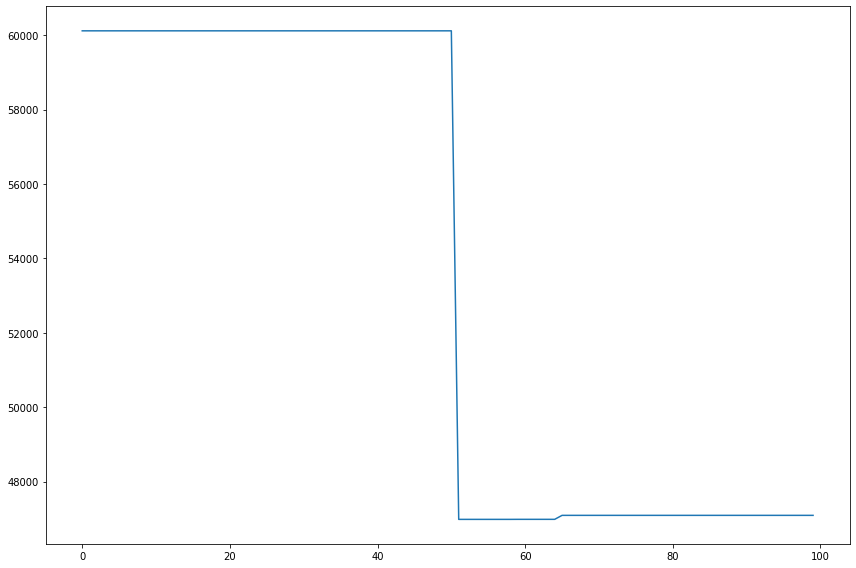

Optimal threshold for the training set: 51


In [ ]:

cmodel = models.RULCostModel(maintenance_cost, safe_interval)

th_range = np.arange(0, 100)
tr_thr = utils.opt_threshold_and_plot(trs.node.values, tr_pred, th_range, cmodel, figsize=(12, 8))
print(f"Optimal threshold for the training set: {tr_thr}")

In [ ]:
tr_set = trs_s.node.unique()
tru_set = tru_s.node.unique()
ts_set = ts_s.node.unique()

tr_c, tr_f, tr_sl = cmodel.cost(trs.node.values, tr_pred, tr_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru.node.values, tru_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts.node.values, ts_pred, tr_thr, return_margin=True)

print(f'Cost: {tr_c} (training), {tru_c} (unsupervised), {ts_c} (test)')

print(f' Avg.fails: {tr_f/len(tr_set)} (training), {tru_f/len(tru_set)} (unsupervised), {ts_f/len(ts_set)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_set)} (training), {tru_sl/len(tru_set)} , {ts_sl/len(ts_set)} (test)')

Cost: 46986 (training), 461503 (unsupervised), 241619 (test)
 Avg.fails: 0.23809523809523808 (training), 0.6551724137931034 (unsupervised), 0.7037037037037037 (test)
Avg. slack: 1045.6190476190477 (training), 395.2586206896552 , 1017.7407407407408 (test)


## supervised 55% unsupervised 20%

In [ ]:
failures = utils.split_by_field(dt, ["node"])

trs_ratio = 0.20
tru_ratio  =0.55
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio, verbose=1, field="node")
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)
tru_s_by_n = utils.split_by_field(tru_s, 'node')
tru_st = utils.cut_off(tru_s, "node")
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1


Num. machine: 21 (supervised), 58 (unsupervised), 27 (test)


### Baseline model

#### Training

In [ ]:
model = models.MLPRegressor(len(dt_in), hidden=[32, 32])
model.compile("Adam", "mse")
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = model.fit(tr_s[dt_in], tr_s['rul'], validation_split=0.2, callbacks=cb, batch_size=batch_size, epochs=25)

Epoch 1/25
528/528 [==============================] - 2s 2ms/step - loss: 0.1249 - val_loss: 0.1807
Epoch 2/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0323 - val_loss: 0.1734
Epoch 3/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0302 - val_loss: 0.1471
Epoch 4/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.1395
Epoch 5/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.1248
Epoch 6/25
528/528 [==============================] - 3s 6ms/step - loss: 0.0158 - val_loss: 0.1134
Epoch 7/25
528/528 [==============================] - 2s 4ms/step - loss: 0.0134 - val_loss: 0.1172
Epoch 8/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0982
Epoch 9/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0907
Epoch 10/25
528/528 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0788

#### Evaluation

Final loss: 0.0034 (training),  0.0566 (validation)


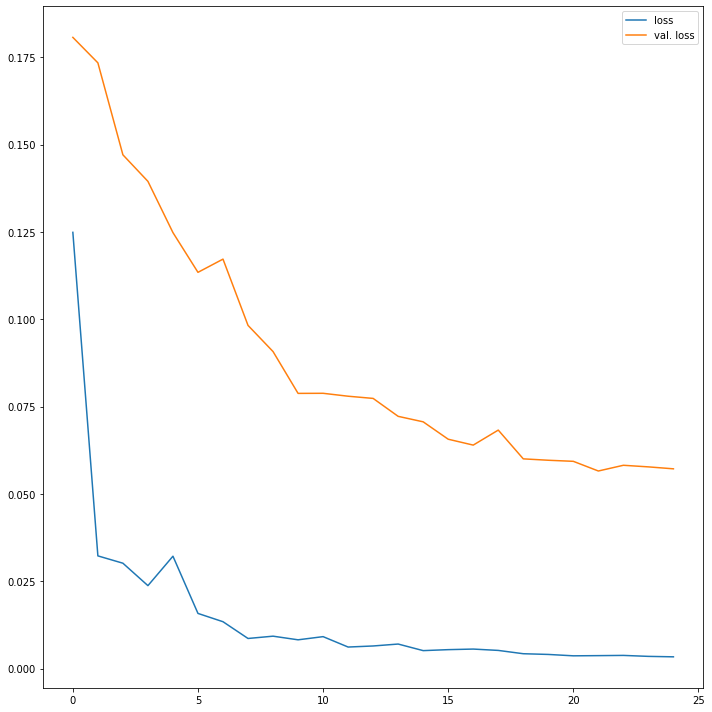

In [ ]:
plot_training_history(history)
trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f"Final loss: {trl:.4f} (training), {vll: .4f} (validation)")

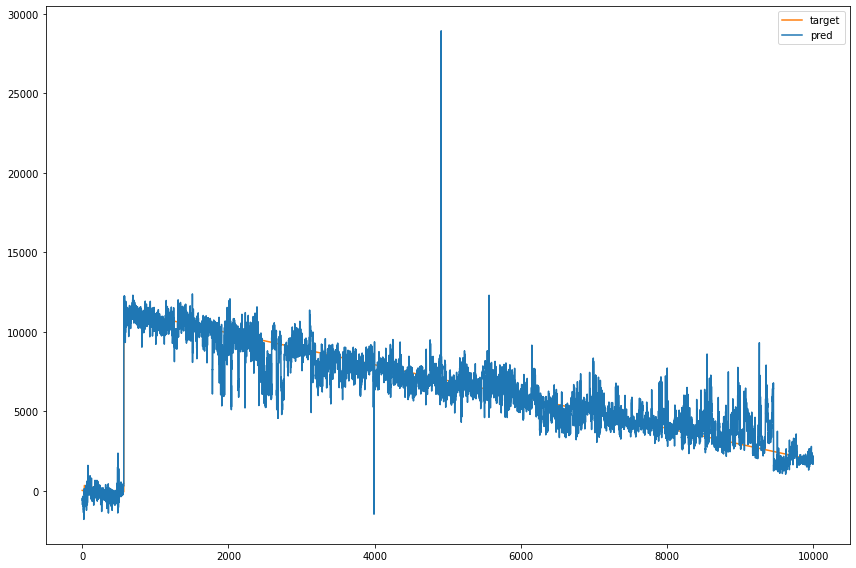

In [ ]:
stop = 10000
tr_pred = model.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tr_pred[:stop], trs['rul'][:stop], figsize=(12,8))

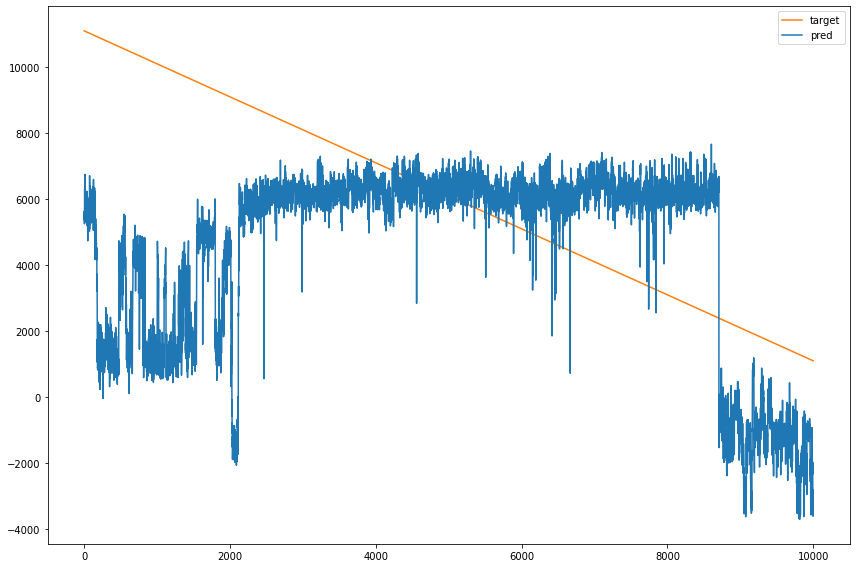

In [ ]:
tru_pred = model.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru['rul'][:stop], figsize=(12,8))

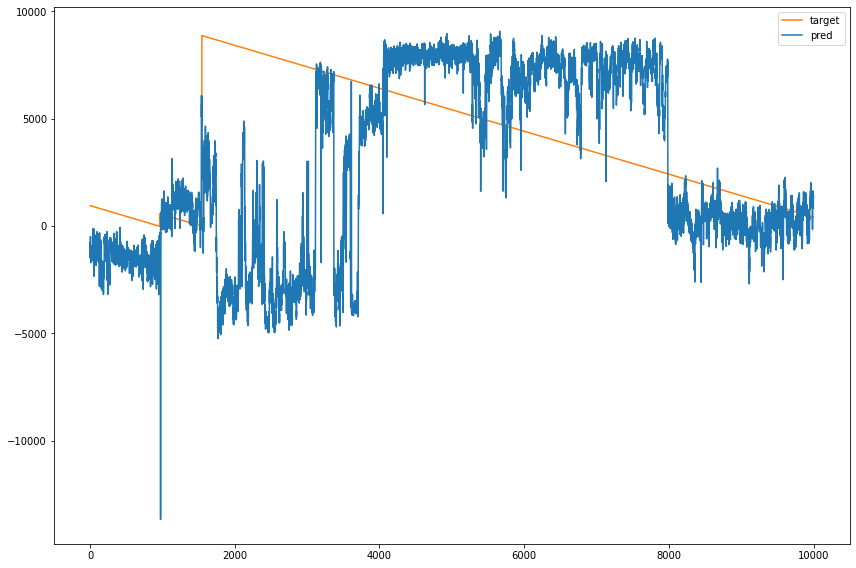

In [ ]:
ts_pred = model.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=(12,8))

In [ ]:
failtimes = dt.groupby(["node"])['cycle'].max()
failtimes.head()

node
r205n12_0      961
r205n12_1       28
r205n12_2      431
r205n12_3      582
r205n12_4    11236
Name: cycle, dtype: int64

In [ ]:
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

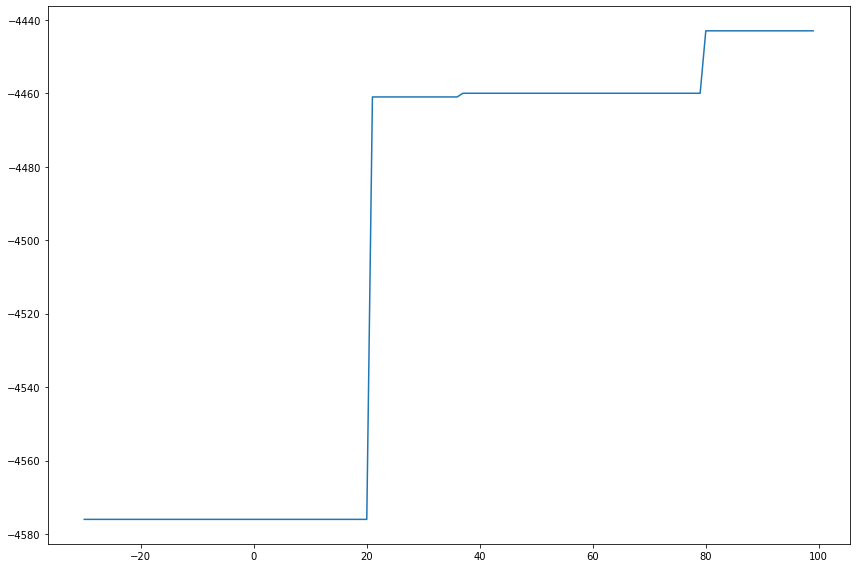

Optimal threshold for the training set: -30


In [ ]:

cmodel = models.RULCostModel(maintenance_cost, safe_interval)

th_range = np.arange(-30, 100)
tr_thr = utils.opt_threshold_and_plot(trs.node.values, tr_pred, th_range, cmodel, figsize=(12, 8))
print(f"Optimal threshold for the training set: {tr_thr}")

In [ ]:
tr_set = trs_s.node.unique()
tru_set = tru_s.node.unique()
ts_set = ts_s.node.unique()

tr_c, tr_f, tr_sl = cmodel.cost(trs.node.values, tr_pred, tr_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru.node.values, tru_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts.node.values, ts_pred, tr_thr, return_margin=True)

print(f'Cost: {tr_c} (training), {tru_c} (unsupervised), {ts_c} (test)')

print(f' Avg.fails: {tr_f/len(tr_set)} (training), {tru_f/len(tru_set)} (unsupervised), {ts_f/len(ts_set)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_set)} (training), {tru_sl/len(tru_set)} , {ts_sl/len(ts_set)} (test)')

Cost: -4576 (training), 76858 (unsupervised), 9866 (test)
 Avg.fails: 0.047619047619047616 (training), 0.1206896551724138 (unsupervised), 0.037037037037037035 (test)
Avg. slack: 1155.8095238095239 (training), 1845.8103448275863 , 2331.4814814814813 (test)


### Lagrangian Regressor model

#### Training

In [ ]:
model = models.LagDualRULRegressor(len(dt_in), trmaxrul, hidden=[32,32])
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size, field="node")
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
model.compile(optimizer='Adam', run_eagerly=False)
history = model.fit(batch_gen, callbacks=cb, epochs=25)


Epoch 1/25
2719/2719 [==============================] - 280s 102ms/step - loss: -0.0364 - mse: 0.0222 - cst: 0.0624
Epoch 2/25
2719/2719 [==============================] - 264s 97ms/step - loss: -0.0145 - mse: 0.0065 - cst: 0.0222
Epoch 3/25
2719/2719 [==============================] - 262s 96ms/step - loss: -0.0137 - mse: 0.0067 - cst: 0.0148
Epoch 4/25
2719/2719 [==============================] - 260s 96ms/step - loss: -0.0094 - mse: 0.0048 - cst: 0.0077
Epoch 5/25
2719/2719 [==============================] - 300s 110ms/step - loss: -0.0073 - mse: 0.0041 - cst: 0.0041
Epoch 6/25
2719/2719 [==============================] - 304s 112ms/step - loss: -0.0107 - mse: 0.0049 - cst: 0.0053
Epoch 7/25
2719/2719 [==============================] - 303s 111ms/step - loss: -0.0058 - mse: 0.0032 - cst: 0.0021
Epoch 8/25
2719/2719 [==============================] - 302s 111ms/step - loss: -0.0056 - mse: 0.0030 - cst: 0.0019
Epoch 9/25
2719/2719 [==============================] - 301s 111ms/step - l

#### Evaluation

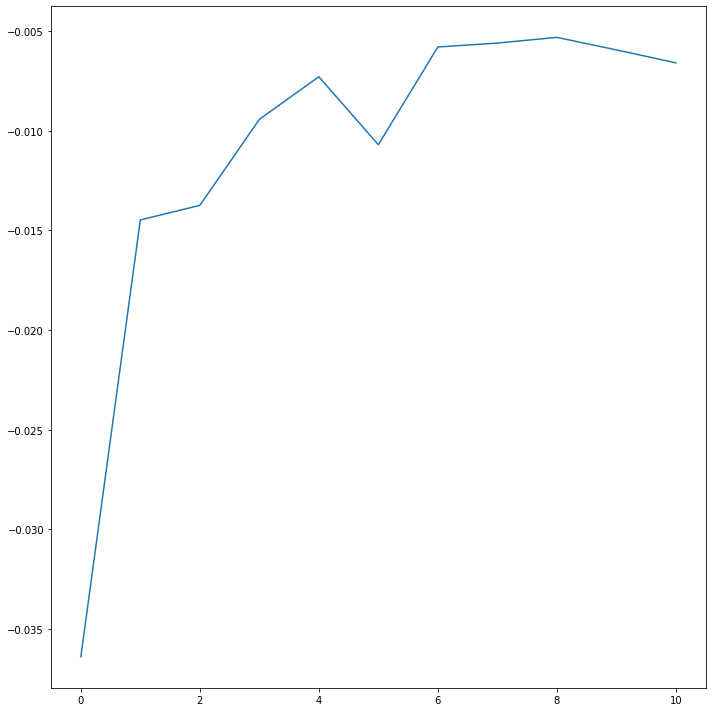

In [ ]:
plot_training_history(history)

In [ ]:
tr_pred = model.predict(trs_s[dt_in]).ravel() * trmaxrul
plot_pred_scatter(tr_pred, trs['rul'])
print(f'R2 score: {r2_score(trs["rul"], tr_pred)}')

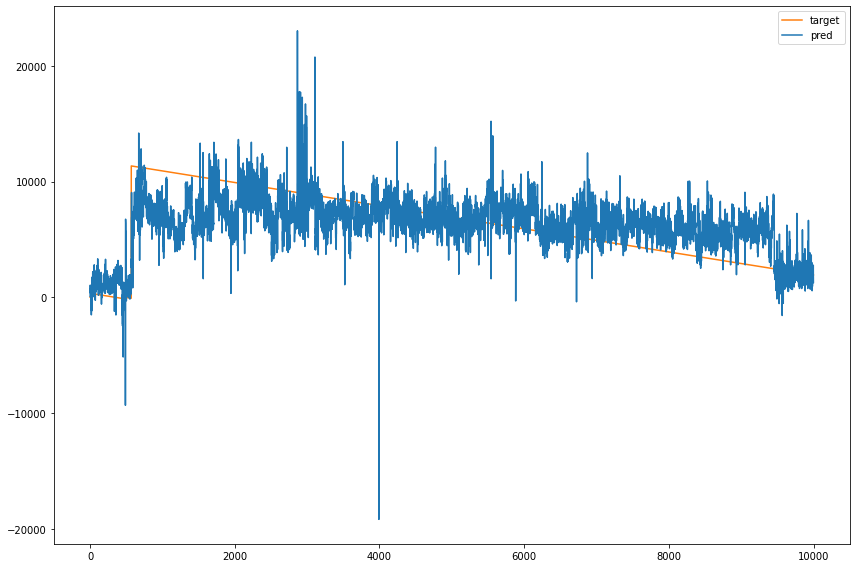

In [ ]:
stop = 10000
utils.plot_rul(tr_pred[:stop], trs['rul'][:stop], figsize=(12,8))

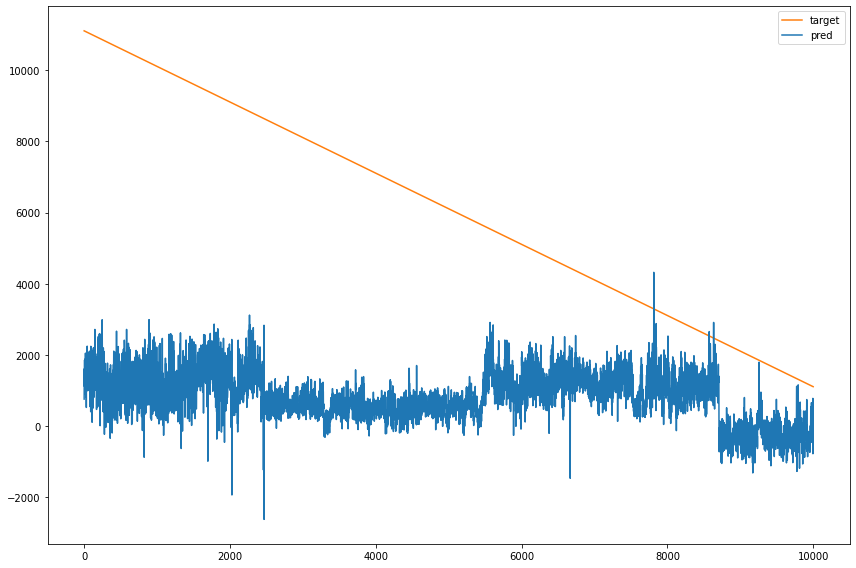

In [ ]:
tru_pred = model.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru['rul'][:stop], figsize=(12,8))

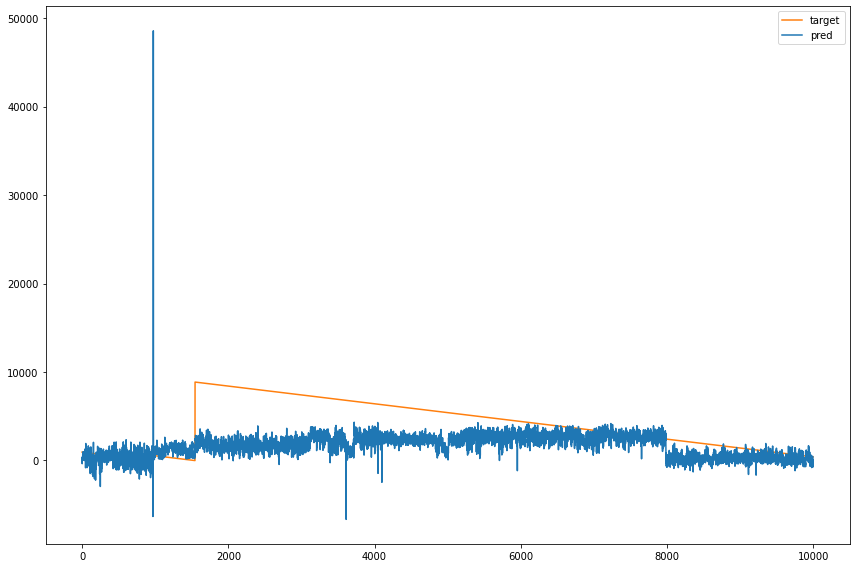

In [ ]:
ts_pred = model.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=(12,8))

In [ ]:
failtimes = dt.groupby(["node"])['cycle'].max()
failtimes.head()

node
r205n12_0      961
r205n12_1       28
r205n12_2      431
r205n12_3      582
r205n12_4    11236
Name: cycle, dtype: int64

In [ ]:
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

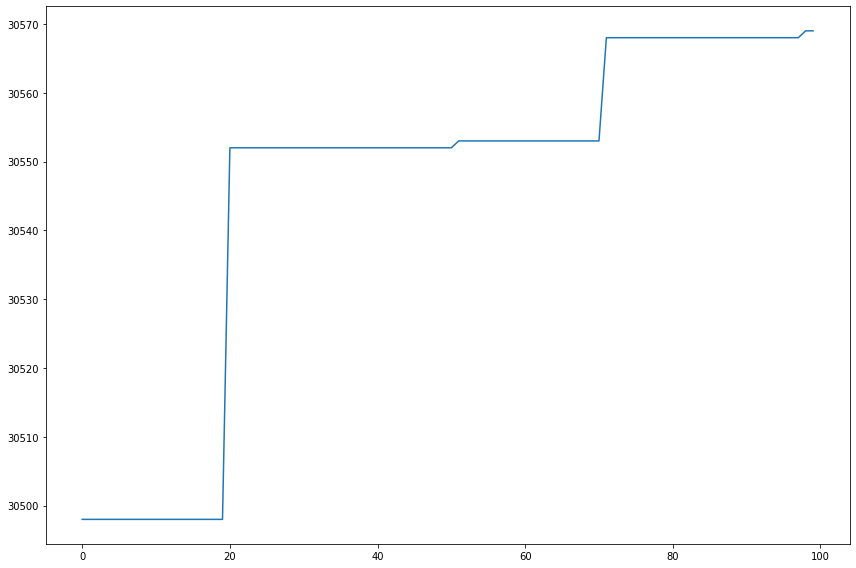

Optimal threshold for the training set: 0


In [ ]:

cmodel = models.RULCostModel(maintenance_cost, safe_interval)

th_range = np.arange(0, 100)
tr_thr = utils.opt_threshold_and_plot(trs.node.values, tr_pred, th_range, cmodel, figsize=(12, 8))
print(f"Optimal threshold for the training set: {tr_thr}")

In [ ]:
tr_set = trs_s.node.unique()
tru_set = tru_s.node.unique()
ts_set = ts_s.node.unique()

tr_c, tr_f, tr_sl = cmodel.cost(trs.node.values, tr_pred, tr_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru.node.values, tru_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts.node.values, ts_pred, tr_thr, return_margin=True)

print(f'Cost: {tr_c} (training), {tru_c} (unsupervised), {ts_c} (test)')

print(f' Avg.fails: {tr_f/len(tr_set)} (training), {tru_f/len(tru_set)} (unsupervised), {ts_f/len(ts_set)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_set)} (training), {tru_sl/len(tru_set)} , {ts_sl/len(ts_set)} (test)')

Cost: 30498 (training), 66248 (unsupervised), 36837 (test)
 Avg.fails: 0.14285714285714285 (training), 0.10344827586206896 (unsupervised), 0.1111111111111111 (test)
Avg. slack: 1498.4761904761904 (training), 1979.3275862068965 , 2318.5925925925926 (test)


In [ ]:
import tensorflow as tf
class CstBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, in_cols, batch_size=32, seed=42, field="machine"):
        super(CstBatchGenerator).__init__()
        self.data = data
        self.in_cols = in_cols
        self.dpm = utils.split_by_field(data, field)
        self.rng = np.random.default_rng(seed)
        self.batch_size = batch_size
        # Build the first sequence of batches
        self.__build_batches()

    def __len__(self):
        return len(self.batches)

    # def __getitem__(self, index):
    #     idx = self.batches[index]
    #     mcn = self.machines[index]
    #     x = self.data[self.in_cols].loc[idx].values
    #     y = self.data['rul'].loc[idx].values
    #     return x, y


    def __getitem__(self, index):
        idx = self.batches[index]
        # mcn = self.machines[index]
        x = self.data[self.in_cols].loc[idx].values
        y = self.data['rul'].loc[idx].values.astype(np.float32)
        flags = (y != -1)
        info = np.vstack((y, flags, idx)).T
        return x, info

    def on_epoch_end(self):
        self.__build_batches()

    def __build_batches(self):
        self.batches = []
        self.machines = []
        # Randomly sort the machines
        # self.rng.shuffle(mcns)
        # Loop over all machines
        mcns = list(self.dpm.keys())
        for mcn in mcns:
            # Obtain the list of indices
            index = self.dpm[mcn].index
            # Padding
            padsize = self.batch_size - (len(index) % self.batch_size)
            padding = self.rng.choice(index, padsize)
            idx = np.hstack((index, padding))
            # Shuffle
            self.rng.shuffle(idx)
            # Split into batches
            bt = idx.reshape(-1, self.batch_size)
            # Sort each batch individually
            bt = np.sort(bt, axis=1)
            # Store
            self.batches.append(bt)
            self.machines.append(np.repeat([mcn], len(bt)))
        # Concatenate all batches
        self.batches = np.vstack(self.batches)
        self.machines = np.hstack(self.machines)
        # Shuffle the batches
        bidx = np.arange(len(self.batches))
        self.rng.shuffle(bidx)
        self.batches = self.batches[bidx, :]
        self.machines = self.machines[bidx]

### Multi Lagrangian Regressor model

#### Training

In [ ]:
model = models.LagDualRULRegressorMulti(len(dt_in), trmaxrul, batch_size-1, hidden=[32,32])
model.compile("Adam")
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size, field="node")
history = model.fit(batch_gen, epochs=25, callbacks=cb)

Epoch 1/25
2719/2719 [==============================] - 238s 87ms/step - loss: -0.0154 - mse: 0.0106 - cst: 0.0247
Epoch 2/25
2719/2719 [==============================] - 230s 84ms/step - loss: -0.0095 - mse: 0.0049 - cst: 0.0072
Epoch 3/25
2719/2719 [==============================] - 227s 84ms/step - loss: -0.0071 - mse: 0.0039 - cst: 0.0034
Epoch 4/25
2719/2719 [==============================] - 228s 84ms/step - loss: -0.0065 - mse: 0.0036 - cst: 0.0022
Epoch 5/25
2719/2719 [==============================] - 227s 84ms/step - loss: -0.0061 - mse: 0.0034 - cst: 0.0014
Epoch 6/25
2719/2719 [==============================] - 227s 83ms/step - loss: -0.0067 - mse: 0.0037 - cst: 0.0011
Epoch 7/25
2719/2719 [==============================] - 227s 83ms/step - loss: -0.0068 - mse: 0.0037 - cst: 8.3764e-04
Epoch 8/25
2719/2719 [==============================] - 227s 83ms/step - loss: -0.0080 - mse: 0.0040 - cst: 7.7270e-04
Epoch 9/25
2719/2719 [==============================] - 226s 83ms/step -

#### Evaluation

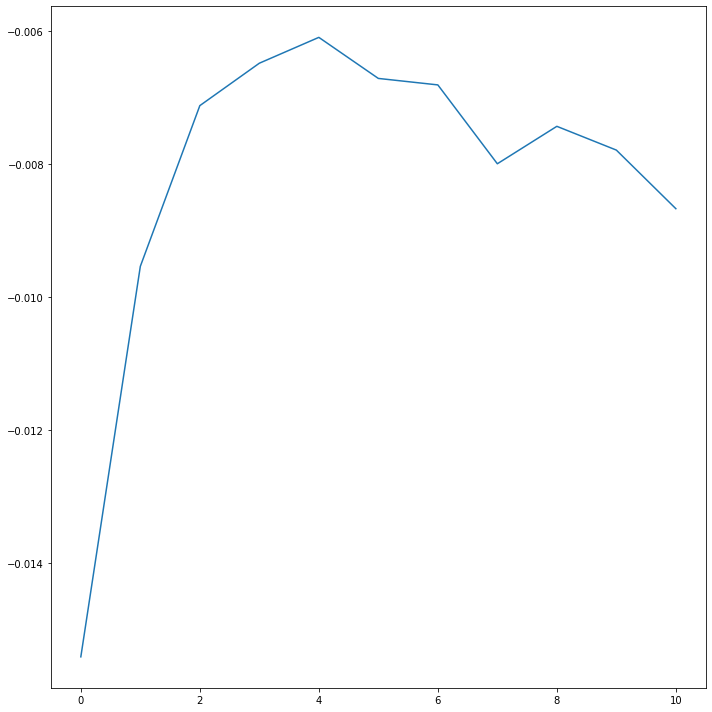

In [ ]:
plot_training_history(history)
# trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
# print(f"Final loss: {trl:.4f} (training), {vll: .4f} (validation)")

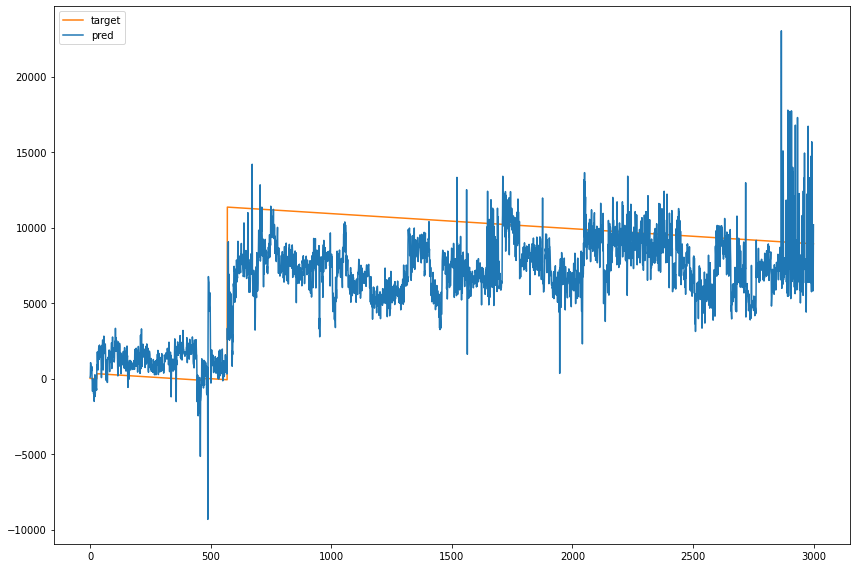

In [ ]:
stop = 3000
utils.plot_rul(tr_pred[:stop], trs['rul'][:stop], figsize=(12,8))

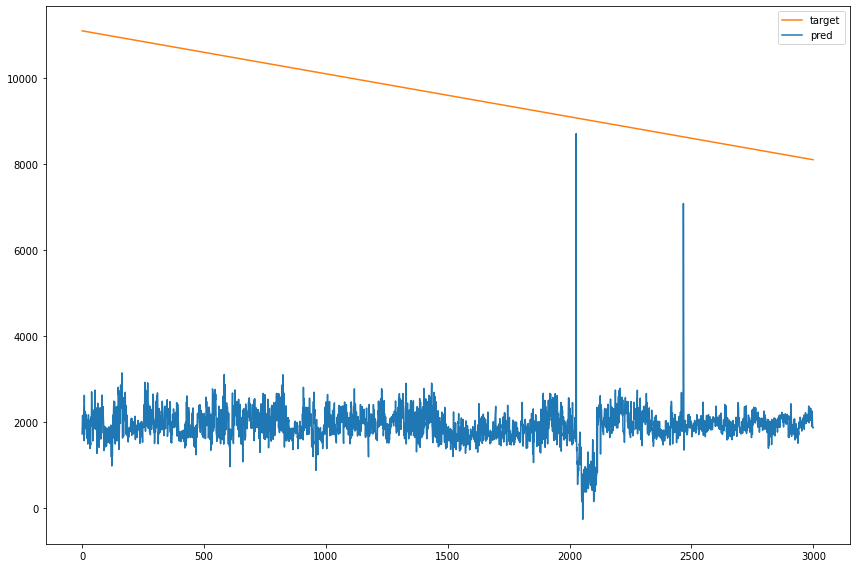

In [ ]:
tru_pred = model.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru['rul'][:stop], figsize=(12,8))

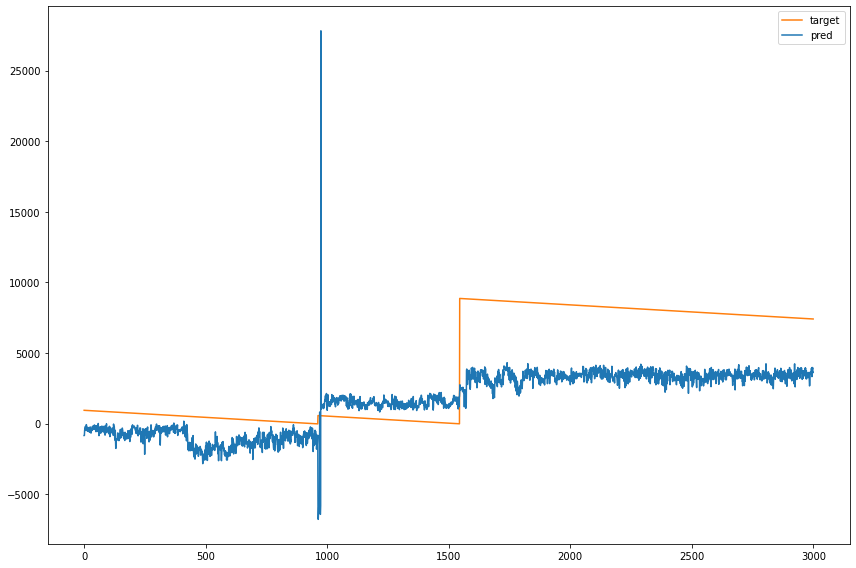

In [ ]:
ts_pred = model.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=(12,8))

In [ ]:
failtimes = dt.groupby(["node"])['cycle'].max()
failtimes.head()

node
r205n12_0      961
r205n12_1       28
r205n12_2      431
r205n12_3      582
r205n12_4    11236
Name: cycle, dtype: int64

In [ ]:
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

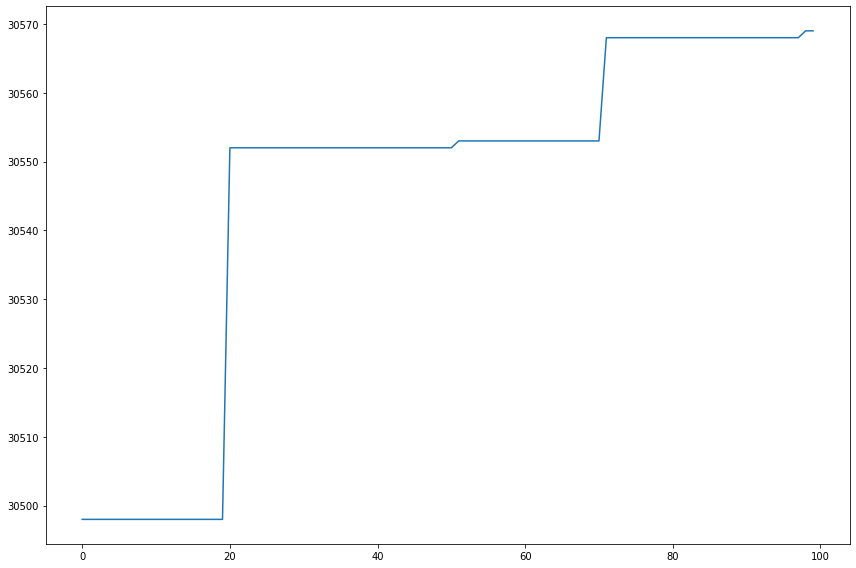

Optimal threshold for the training set: 0


In [ ]:

cmodel = models.RULCostModel(maintenance_cost, safe_interval)

th_range = np.arange(0, 100)
tr_thr = utils.opt_threshold_and_plot(trs.node.values, tr_pred, th_range, cmodel, figsize=(12, 8))
print(f"Optimal threshold for the training set: {tr_thr}")

In [ ]:
tr_set = trs_s.node.unique()
tru_set = tru_s.node.unique()
ts_set = ts_s.node.unique()

tr_c, tr_f, tr_sl = cmodel.cost(trs.node.values, tr_pred, tr_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru.node.values, tru_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts.node.values, ts_pred, tr_thr, return_margin=True)

print(f'Cost: {tr_c} (training), {tru_c} (unsupervised), {ts_c} (test)')

print(f' Avg.fails: {tr_f/len(tr_set)} (training), {tru_f/len(tru_set)} (unsupervised), {ts_f/len(ts_set)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_set)} (training), {tru_sl/len(tru_set)} , {ts_sl/len(ts_set)} (test)')

Cost: 30498 (training), 220222 (unsupervised), 134534 (test)
 Avg.fails: 0.14285714285714285 (training), 0.3275862068965517 (unsupervised), 0.4074074074074074 (test)
Avg. slack: 1498.4761904761904 (training), 1216.0344827586207 , 1384.4814814814815 (test)
